In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


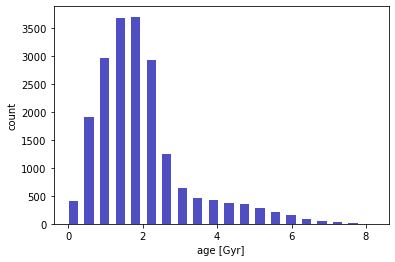

In [3]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


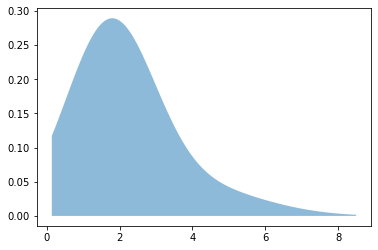

In [4]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.16134894568048957
0.13801577758850292
20000 [1.96212212 1.11792793 1.16807808 ... 3.10721722 1.79495495 3.91797798]


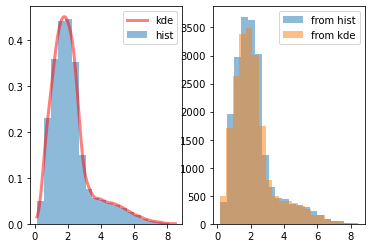

[1.96212212 1.11792793 1.16807808 ... 3.10721722 1.79495495 3.91797798]


In [5]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1_kde)

60000 [204.59450538   3.13973777  52.68725805 ...   2.87788562 164.24207446
 182.55125987]
[25338  7634  4627  3425  2582  2096  1812  1550  1416  1255  1096  1050
   982   877   861   725   693   694   660   627]
[  2.00006808  16.89993516  31.79980223  46.69966931  61.59953638
  76.49940346  91.39927053 106.29913761 121.19900468 136.09887176
 150.99873883 165.89860591 180.79847298 195.69834006 210.59820713
 225.49807421 240.39794128 255.29780836 270.19767543 285.09754251
 299.99740958]


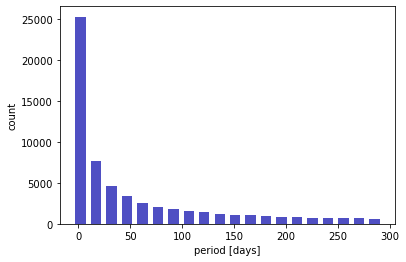

In [6]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[2998 3001 2912 3036 3053 2963 2968 2893 3010 2961 3034 3054 3000 3058
 2999 2976 3026 3003 3038 3017]
[0.69318122 0.94371085 1.19424048 1.44477011 1.69529974 1.94582938
 2.19635901 2.44688864 2.69741827 2.9479479  3.19847753 3.44900716
 3.69953679 3.95006642 4.20059605 4.45112569 4.70165532 4.95218495
 5.20271458 5.45324421 5.70377384]


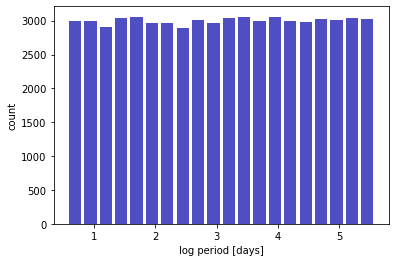

In [7]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Case 2

1.1170311000339714
0.20889447103113198
2000 [0.43355355 0.78392392 0.62982983 ... 0.81233233 0.46884885 0.57043043]


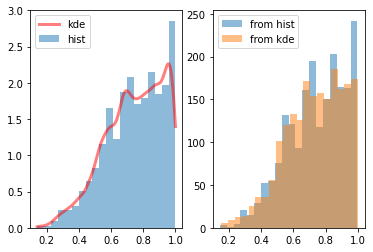

In [8]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr? yes
# going back and using a threshold of 1 Gyr like Berger et al 2020 b/c the proportion of young/old is more realistic
young = berger_kepler.loc[berger_kepler.iso_age <= 1.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 1.].iso_age

stars_age2_young_kde, stars_age2_young_cdf = run_kde(young, 2000)

11000 [ 10.26629405  53.72970259  40.420023   ... 190.91903706  22.63069098
   4.4480253 ]
[4720 1383  799  623  490  393  336  294  231  224  216  172  170  183
  166  124  137  120  120   99]
[  2.00017515  16.89685321  31.79353126  46.69020932  61.58688738
  76.48356543  91.38024349 106.27692155 121.1735996  136.07027766
 150.96695572 165.86363377 180.76031183 195.65698988 210.55366794
 225.450346   240.34702405 255.24370211 270.14038017 285.03705822
 299.93373628]


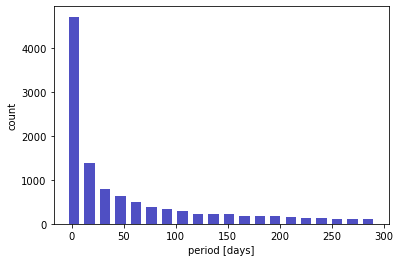

In [9]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.16776569556283707
0.14178034518473398
18000 [3.05408408 4.73128128 4.59650651 ... 1.81864865 4.79118118 1.44427427]


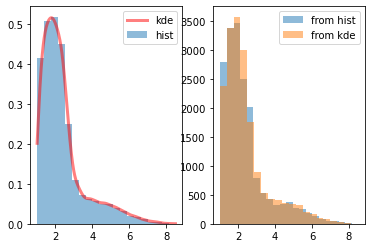

In [10]:
stars_age2_old_kde, stars_age2_old_cdf = run_kde(old, 18000)

27000 [ 8.14275623  2.71120568  3.51249185 ... 31.18871364 16.32248488
  4.19048566]
[11442  3421  2057  1611  1205   879   737   741   668   574   503   457
   391   390   389   360   301   298   273   303]
[  2.00002672  16.89954667  31.79906662  46.69858658  61.59810653
  76.49762648  91.39714643 106.29666639 121.19618634 136.09570629
 150.99522624 165.8947462  180.79426615 195.6937861  210.59330605
 225.49282601 240.39234596 255.29186591 270.19138587 285.09090582
 299.99042577]


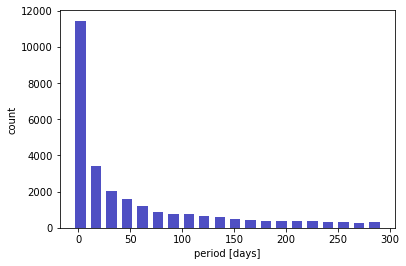

In [11]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

In [ ]:
"""# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution, 2 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()
"""

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [12]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)]))
print(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[1.96212212 1.11792793 1.16807808 ... 1.86182182 2.96512513 1.92033033]


We'll go ahead and use 1 Gyr for now; we'll know from the transit simulation work whether a compact multi rate of 12.6% is consistent with the observed Kepler sample. Tuning this to get it to reproduce Kepler observations will be one of the next few steps anyway.

[ 397 1565 2602 3861 3825 2916 1441  716  486  453  417  372  334  216
  167  113   69   34   13    3]
[0.15377377 0.57058509 0.9873964  1.40420771 1.82101902 2.23783033
 2.65464164 3.07145295 3.48826426 3.90507558 4.32188689 4.7386982
 5.15550951 5.57232082 5.98913213 6.40594344 6.82275475 7.23956607
 7.65637738 8.07318869 8.49      ]


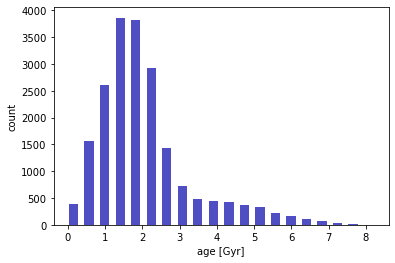

In [13]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars 
# drawn from two piecewise KDEs of the Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young_kde)+list(stars_age2_old_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.16134894568048957
0.13801577758850292
5158
34842


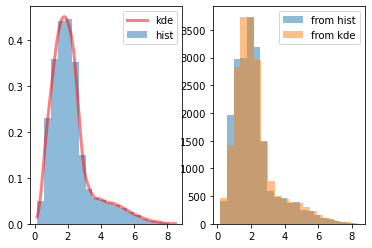

2000 18000


In [14]:
# maybe that was a bad idea to draw two separate piecewise KDEs
# instead, let's use the same KDE from Case 1 and just draw until we get 2000 young and 18000 old stars
def generate_rand_from_pdf_case2(pdf, x_grid, n_young, n_old):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(2*(n_young+n_old))
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    # select 2000 young from Case 1 KDE draw
    case2_young = [i for i in random_from_cdf if i <= 1.]
    print(len(case2_young))
    case2_young = random.sample(case2_young, 2000)
    # else select old
    case2_old = [i for i in random_from_cdf if i > 1.]
    print(len(case2_old))
    case2_old = random.sample(case2_old, 18000)
    return case2_young, case2_old

def run_kde_case2(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde_young, random_from_kde_old = generate_rand_from_pdf_case2(kdepdf, x_grid, 2000, 18000) # generate random data from KDE distribution
    #print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(list(random_from_kde_young)+list(random_from_kde_old), nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde_young, random_from_kde_old

stars_age2_kde_young, stars_age2_kde_old = run_kde_case2(berger_kepler.iso_age, 20000)
print(len(stars_age2_kde_young), len(stars_age2_kde_old))

[ 460 1422 2839 3728 3713 2953 1469  764  508  445  385  373  295  239
  166  107   64   40   24    6]
[0.14       0.55164915 0.9632983  1.37494745 1.7865966  2.19824575
 2.60989489 3.02154404 3.43319319 3.84484234 4.25649149 4.66814064
 5.07978979 5.49143894 5.90308809 6.31473724 6.72638639 7.13803554
 7.54968468 7.96133383 8.37298298]


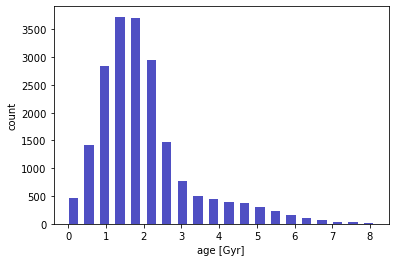

In [15]:
# age histogram for the Case 2 young and old stars, drawn from one continuous KDE fitted to Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_kde_young)+list(stars_age2_kde_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

[ 487 1712 2630 3376 3497 3009 1750  775  500  414  406  368  320  267
  161  154   86   50   30    8]
[0.14       0.53326076 0.92652152 1.31978228 1.71304304 2.1063038
 2.49956456 2.89282533 3.28608609 3.67934685 4.07260761 4.46586837
 4.85912913 5.25238989 5.64565065 6.03891141 6.43217217 6.82543293
 7.21869369 7.61195445 8.00521522]


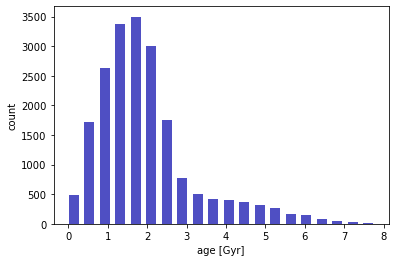

In [16]:
# age histogram for the Case 1 stars
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age1_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [17]:
len([i for i in stars_age1_kde if i <= 1.])

2566

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


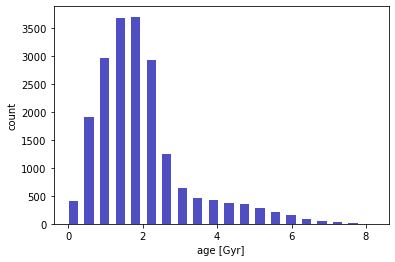

In [18]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

So there's three ways I can go about this. Do I 1) sample from 2 piecewise KDEs fit onto the <1 and >1 parts of the Berger age distribution; 2) sample generously from a single KDE on the Berger age distribution and draw however much I need from the <1 and >1 portions; or 3) just use the KDE from Case 1? Also, should I really be sampling 10%/90% if the true threshold is at 12.6%? If I do that, I'm undersampling for the already smaller young sample. And if I don't do that, then I might as well take option 3, right? <br> <br>

Let's just use the synthetic stars from Case 1 for now and fall back on different sampling proportions if the transit work doesn't look right, as Sarah said.

### Transits

0.38690748364419597
0.13801577758850292
20000 [2.14046246 2.26263664 2.4138999  ... 2.73387988 2.25681882 2.10555556]


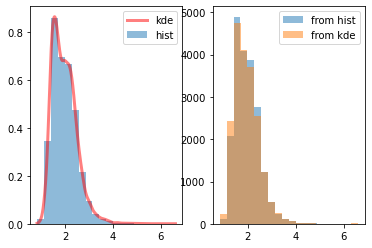

In [19]:
stars_radius_kde, stars_radius_cdf = run_kde(berger_kepler.iso_rad, 20000)

In [72]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 1

midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
transit_multiplicities = []
#planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2
for star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    inclinations.append(np.random.normal(mu, sigma, 3)) # create impact params for planets
    inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, 3)) # create impact params for planets in degrees
    
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

planets_per_case1 = [planets_per1[p:p+3] for p in range(0, len(planets_per1), 3)] # reorganize list into list of lists of three

planets_a1 = planets_per1**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
planets_a_case1 = [planets_a1[a:a+3] for a in range(0, len(planets_a1), 3)] # reorganize as with periods

# calculate impact parameters for 60000 planets; explode inclinations list and repeat star radius for its 3 planets
b = (planets_a1 * np.sin(np.concatenate(inclinations, axis=0)))/np.repeat(stars_radius_kde, 3)

# wrap back up into list of lists
impact_parameters = [b[i:i+3] for i in range(0, len(b), 3)]

# count number of transiting planets per star, ie. planets where |b| <= 1
for star in impact_parameters:
    transit_multiplicities.append(len([planet for planet in star if np.abs(planet) <= 1.]))

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1, 'semi_major_axes': planets_a_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees,
                 'star_radius': stars_radius_kde, 'impact_parameters': impact_parameters}
transits_case1 = pd.DataFrame(transits_dict)

transits_case1['transit_multiplicity'] = transit_multiplicities
print(transits_case1.head())

   star_ages                                     planet_periods  \
0   1.962122  [204.59450538248632, 3.1397377671766757, 52.68...   
1   1.117928  [199.64378742080356, 2.9532227456509386, 145.9...   
2   1.168078  [60.43059446034073, 2.0268977276345486, 2.6490...   
3   1.995556  [145.00393202822073, 100.76237663862891, 66.50...   
4   3.500060  [6.143625102823588, 2.588115998049048, 23.8373...   

                                     semi_major_axes  midplane  \
0  [34.72130001186483, 2.1441849894156224, 14.054...  0.390505   
1  [34.15889920702659, 2.05840488147465, 27.71994... -1.462813   
2  [15.399427575886918, 1.6016018330739399, 1.914... -0.635849   
3  [27.60068449592604, 21.653707615191347, 16.414... -1.490816   
4  [3.3544125236789264, 1.8850483392920836, 8.282... -0.527023   

        midplane_degrees                                planet_inclinations  \
0   [23.635341169039577]  [0.3843432353778422, 0.38314186167997166, 0.40...   
1   [12.064516433514186]  [-1.419998082134

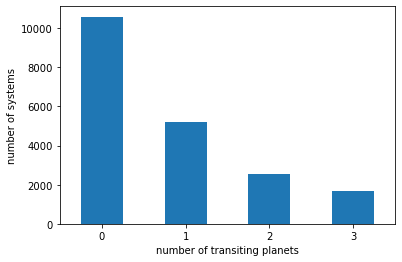

In [54]:
# plot transit multiplicity 
transits_case1.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')
plt.show()

In [77]:
# calculate xi = (transit duration of planet 1 divided by p1^1/3) / (transit duration of planet 2 divided by p2^1/3)
# where transit duration = P/pi * arcsin(sqrt((R* + Rp)^2 - (b R*)^2) / a)
# Rp placeholder of 1% stellar radius
sqrt_arg = (transits_case1.star_radius + 0.01 * transits_case1.star_radius)**2 + (transits_case1.impact_parameters * transits_case1.star_radius)**2
print(sqrt_arg)
transit_duration = (transits_case1.planet_periods/np.pi) * (np.arcsin(np.sqrt(sqrt_arg))/transits_case1.semi_major_axes)

# plot histogram of distribution of xi's across all systems

0        [174.16189046939772, 5.316190712653062, 35.425...
1        [1145.7194885485865, 9.423052132506772, 766.11...
2        [92.44486099422195, 7.049850808130413, 7.19083...
3        [761.6807717368362, 469.92151884482166, 272.39...
4        [7.447488850562728, 4.9704557272164855, 23.632...
                               ...                        
19995    [11.62545630570566, 543.2620996163434, 32.3103...
19996    [4.377008375046236, 5.349225652250473, 17.2683...
19997    [135.18689543045187, 7.844915565169975, 13.610...
19998    [159.22637515724043, 13.134718175878545, 1668....
19999    [4.657500441833198, 36.15337782353065, 50.0191...
Length: 20000, dtype: object
3


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable sqrt method

In [ ]:
# calculate xi = (transit duration of planet 1 divided by p1^1/3) / (transit duration of planet 2 divided by p2^1/3)
# where transit duration = P/pi * arcsin(sqrt((R* + Rp)^2 - (b R*)^2) / a)
sqrt_arg = (transits_case1.star_radius + ???)**2 + (transits_case1.impact_parameters * transits_case1.star_radius)**2
transit_duration = (transits_case1.planets_per_case1/np.pi) * (np.arcsin(np.sqrt(sqrt_arg))/transits_case1.planets_a_case1)

# plot histogram of distribution of xi's across all systems

In [69]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
planets_a_case2 = []
star_radius = []
impact_parameters = []
transit_multiplicities = []
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2

for r_star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    if r_star <= 1.:
        num_planets = random.choice([5, 6]) # young system has 5 or 6 planets
        
        # draw 5 or 6 planet periods from loguniform distribution
        planet_per_case2 = loguniform.rvs(2, 300, size=num_planets) 
        planets_per_case2.append(planet_per_case2) 
        
        # incliations for impact parameter formula
        inclination = np.random.normal(mu, sigma, num_planets) # need this for later
        inclinations.append(inclination) 
        inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 
        
        # semi-major axes
        planet_a_case2 = planet_per_case2**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
        planets_a_case2.append(planet_a_case2) 
    
        # calculate impact parameters
        b = (planet_a_case2 * np.sin(inclination))/r_star
        impact_parameters.append(b)

        # transit check based on impact parameters
        transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
        
    elif r_star > 1.:
        num_planets = random.choice([2, 3]) # old system has 1 or 2 planets
        
        # draw 1 or 2 planet periods from loguniform distribution
        planet_per_case2 = loguniform.rvs(2, 300, size=num_planets)
        planets_per_case2.append(planet_per_case2) # draw 5 or 6 planet periods from loguniform distribution
        
        # inclinations for impact parameter formula
        inclination = np.random.normal(mu, sigma, num_planets) # need this for later
        inclinations.append(inclination)
        inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 
        
        # semi-major axes
        planet_a_case2 = planet_per_case2**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
        planets_a_case2.append(planet_a_case2) 
        
        # calculate impact parameters
        b = (planet_a_case2 * np.sin(inclination))/r_star
        impact_parameters.append(b)

        # transit check based on impact parameters
        transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list


transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 'semi_major_axes': planets_a_case2,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                 'impact_parameters': impact_parameters, 'transit_multiplicity': transit_multiplicities}

transits_case2 = pd.DataFrame(transits_dict)
print(transits_case2.head())

   star_ages                                     planet_periods  \
0   1.962122  [4.400283751630219, 21.901993391631322, 236.30...   
1   1.117928  [285.457927809775, 43.07693785152397, 209.2328...   
2   1.168078  [9.047219304338087, 15.235170825720125, 24.298...   
3   1.995556  [12.383759596312162, 9.754524651831439, 19.836...   
4   3.500060            [86.01662458457386, 107.39863050208534]   

                                     semi_major_axes  midplane  \
0  [2.6852648183383208, 7.828089139657009, 38.222... -1.416959   
1  [43.35389012057561, 12.28843422169448, 35.2441...  0.313153   
2  [4.34186929076054, 6.145608428393084, 8.389140...  0.683209   
3  [5.352643777195924, 4.565314914142445, 7.32784... -1.263523   
4            [19.48595061201529, 22.594314121431125] -0.191455   

        midplane_degrees                                planet_inclinations  \
0   [-5.550771500514443]  [-1.4481981124381536, -1.4127672804663685, -1....   
1     [72.4435085193468]  [0.3315962192160

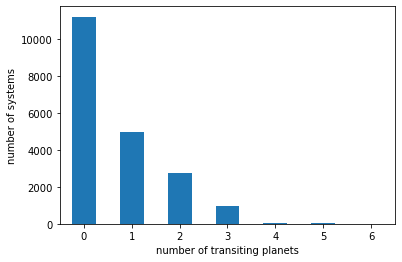

In [68]:
# plot transit multiplicity 
transits_case2.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')
plt.show()